# Movie Recommendation System (MovieLens 100K — using u1.base & u1.test)

This notebook:
- Loads `u1.base` (train), `u1.test` (test) and `u.item` (movie titles).
- Shows simple EDA charts.
- Implements: user-based CF, item-based CF, and SVD baseline.
- Evaluates with Precision@K and shows recommendations.

Make sure `u1.base`, `u1.test`, `u.item` are uploaded to the notebook environment.


In [1]:

!pip install pandas numpy scipy scikit-learn matplotlib

print("If you already have pandas, numpy, scikit-learn and matplotlib, you're good.")


If you already have pandas, numpy, scikit-learn and matplotlib, you're good.


In [2]:
import os
import numpy as np
import pandas as pd
from math import floor
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

# For reproducibility
np.random.seed(2025)
print("imports OK")


imports OK


In [3]:
# File names (change if you placed files in a folder)
train_file = 'u1.base'
test_file = 'u1.test'
item_file = 'u.item'

cols = ['user_id', 'item_id', 'rating', 'timestamp']

# Load train and test (tab-separated, no header)
train = pd.read_csv(train_file, sep='\t', names=cols, encoding='latin-1')
test  = pd.read_csv(test_file,  sep='\t', names=cols, encoding='latin-1')

print('Train shape:', train.shape)
print('Test shape :', test.shape)

# Load movie metadata (we'll use id and title)
movies = pd.read_csv(item_file, sep='|', header=None, encoding='latin-1')
movies = movies[[0,1]].rename(columns={0:'movie_id', 1:'title'})
print('Movies shape:', movies.shape)

# Quick peek
display(train.head())
display(movies.head())


Train shape: (80000, 4)
Test shape : (20000, 4)
Movies shape: (1682, 2)


,user_id,item_id,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


,movie_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


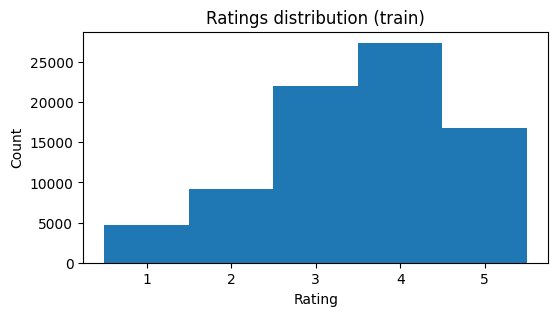

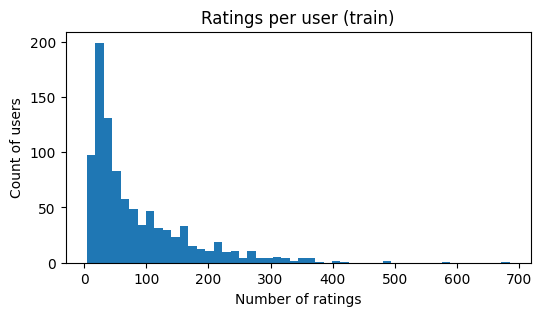

Avg ratings per user (train): 84.83563096500531


In [4]:
# Ratings distribution (train)
plt.figure(figsize=(6,3))
plt.hist(train['rating'].values, bins=np.arange(1,7)-0.5)
plt.title('Ratings distribution (train)')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks([1,2,3,4,5])
plt.show()

# Ratings per user
ratings_per_user = train.groupby('user_id').size()
plt.figure(figsize=(6,3))
plt.hist(ratings_per_user.values, bins=50)
plt.title('Ratings per user (train)')
plt.xlabel('Number of ratings')
plt.ylabel('Count of users')
plt.show()

print("Avg ratings per user (train):", ratings_per_user.mean())


In [5]:
# Create maps from ids to indices (only use users/items present in these splits)
all_users = sorted(pd.concat([train['user_id'], test['user_id']]).unique())
all_items = sorted(pd.concat([train['item_id'], test['item_id']]).unique())

user_map = {uid: i for i, uid in enumerate(all_users)}
item_map = {iid: i for i, iid in enumerate(all_items)}
inv_item_map = {v:k for k,v in item_map.items()}

n_users = len(all_users)
n_items = len(all_items)
print('n_users, n_items =', n_users, n_items)

def build_matrix(df):
    M = np.zeros((n_users, n_items), dtype=np.float32)
    for _, row in df.iterrows():
        u = user_map[row['user_id']]
        i = item_map[row['item_id']]
        M[u, i] = row['rating']
    return M

R_train = build_matrix(train)
R_test  = build_matrix(test)
print('R_train shape:', R_train.shape, 'R_test shape:', R_test.shape)


n_users, n_items = 943 1682
R_train shape: (943, 1682) R_test shape: (943, 1682)


In [6]:
# Similarities
def compute_user_similarity(R):
    sim = cosine_similarity(R)
    np.fill_diagonal(sim, 0.0)
    return sim

def compute_item_similarity(R):
    sim = cosine_similarity(R.T)
    np.fill_diagonal(sim, 0.0)
    return sim

# Predict using top-k user neighbors
def predict_user_based(R_train, user_sim, k=20):
    n_users, n_items = R_train.shape
    pred = np.zeros_like(R_train, dtype=np.float32)
    for u in range(n_users):
        neighbors_idx = np.argsort(user_sim[u])[-k:]
        sims = user_sim[u, neighbors_idx]
        neigh_ratings = R_train[neighbors_idx]
        denom = np.abs(sims).sum()
        if denom == 0:
            denom = 1e-9
        pred[u] = (sims @ neigh_ratings) / denom
    return pred

# Predict using item-based CF
def predict_item_based(R_train, item_sim, k=20):
    n_users, n_items = R_train.shape
    pred = np.zeros_like(R_train, dtype=np.float32)
    for i in range(n_items):
        neighbors_idx = np.argsort(item_sim[i])[-k:]
        sims = item_sim[i, neighbors_idx]
        neigh = R_train[:, neighbors_idx]
        denom = np.abs(sims).sum()
        if denom == 0:
            denom = 1e-9
        pred[:, i] = (neigh @ sims) / denom
    return pred

# SVD baseline
def svd_predict(R_train, n_components=50):
    svd = TruncatedSVD(n_components=min(n_components, R_train.shape[1]-1), random_state=2025)
    U = svd.fit_transform(R_train)
    VT = svd.components_
    R_hat = U @ VT
    return R_hat

print("Functions ready")


Functions ready


Computing similarities (may take a moment)...
Generating predictions...
Precision@5: userCF=0.4272, itemCF=0.3031, SVD=0.3855
Precision@10: userCF=0.3669, itemCF=0.2651, SVD=0.3349
Precision@20: userCF=0.2963, itemCF=0.2330, SVD=0.2671


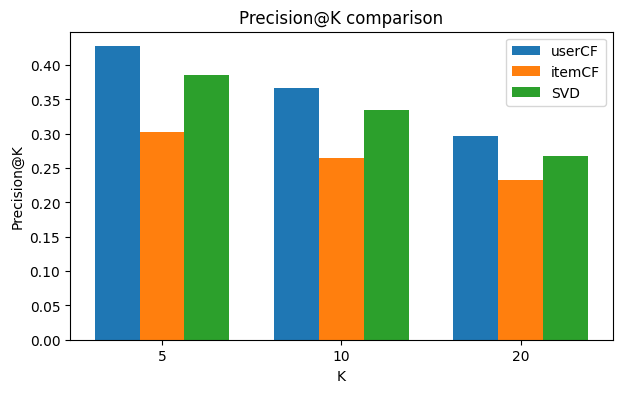

In [7]:
def precision_at_k(pred_matrix, test_matrix, K=10, threshold=4.0):
    n_users = pred_matrix.shape[0]
    precisions = []
    for u in range(n_users):
        scores = pred_matrix[u]
        seen = R_train[u] > 0
        scores_masked = scores.copy()
        scores_masked[seen] = -np.inf
        topk_idx = np.argsort(scores_masked)[-K:][::-1]
        relevant = (test_matrix[u] >= threshold)
        if relevant.sum() == 0:
            continue
        hits = relevant[topk_idx].sum()
        precisions.append(hits / K)
    if len(precisions) == 0:
        return 0.0
    return np.mean(precisions)

print("Computing similarities (may take a moment)...")
user_sim = compute_user_similarity(R_train)
item_sim = compute_item_similarity(R_train)

print("Generating predictions...")
pred_user = predict_user_based(R_train, user_sim, k=20)
pred_item = predict_item_based(R_train, item_sim, k=20)
pred_svd  = svd_predict(R_train, n_components=50)

results = {}
for K in (5, 10, 20):
    p_user = precision_at_k(pred_user, R_test, K=K, threshold=4.0)
    p_item = precision_at_k(pred_item, R_test, K=K, threshold=4.0)
    p_svd  = precision_at_k(pred_svd,  R_test, K=K, threshold=4.0)
    results[K] = {'userCF': p_user, 'itemCF': p_item, 'SVD': p_svd}
    print(f"Precision@{K}: userCF={p_user:.4f}, itemCF={p_item:.4f}, SVD={p_svd:.4f}")

# Plot comparison
Ks = sorted(results.keys())
user_vals = [results[K]['userCF'] for K in Ks]
item_vals = [results[K]['itemCF'] for K in Ks]
svd_vals  = [results[K]['SVD'] for K in Ks]

x = np.arange(len(Ks))
width = 0.25
plt.figure(figsize=(7,4))
plt.bar(x - width, user_vals, width, label='userCF')
plt.bar(x,        item_vals, width, label='itemCF')
plt.bar(x + width, svd_vals, width, label='SVD')
plt.xticks(x, [str(k) for k in Ks])
plt.xlabel('K')
plt.ylabel('Precision@K')
plt.title('Precision@K comparison')
plt.legend()
plt.show()


In [8]:
def recommend_topk(pred_matrix, user_id, K=10):
    if user_id not in user_map:
        raise ValueError('user_id not found in the loaded splits')
    u = user_map[user_id]
    scores = pred_matrix[u]
    seen = R_train[u] > 0
    scores_masked = scores.copy()
    scores_masked[seen] = -np.inf
    top_idx = np.argsort(scores_masked)[-K:][::-1]
    return [inv_item_map[i] for i in top_idx], scores_masked[top_idx]

# Example: recommend for the first user in train data
example_user = sorted(set(train['user_id']))[0]
print('Example user id:', example_user)
recs, scores = recommend_topk(pred_user, example_user, K=10)

title_map = movies.set_index('movie_id')['title'].to_dict()
for iid, sc in zip(recs, scores):
    print(title_map.get(iid, str(iid)), f"(score {sc:.3f})")


Example user id: 1
Raiders of the Lost Ark (1981) (score 4.506)
Terminator 2: Judgment Day (1991) (score 4.449)
Silence of the Lambs, The (1991) (score 4.260)
Usual Suspects, The (1995) (score 4.259)
Fargo (1996) (score 4.157)
Pulp Fiction (1994) (score 4.088)
Forrest Gump (1994) (score 3.910)
E.T. the Extra-Terrestrial (1982) (score 3.816)
Shawshank Redemption, The (1994) (score 3.616)
Alien (1979) (score 3.598)


## Notes & next steps
- Improvements: mean-centering (subtract user mean), shrinkage, weighting by co-ratings, using Surprise library (SVD++), implicit ALS.
- If you'd like: I can create an auto-run Colab link, or update the notebook to run cross-fold evaluation using all u*.base/u*.test pairs.
